In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

%matplotlib inline

## Generators

In [8]:
def first_generator(lambda_):
    xi = np.random.uniform(0, 1)
    return -(1 / lambda_) * math.log(xi)

def second_generator(sigma, a):
    mu = sum([np.random.uniform(0, 1) for _ in range(12)]) - 6
    return sigma * mu + a

def third_generator(a=5 ** 13, c=2 ** 31):
    zi = np.random.uniform(0, 1)
    return ((a * zi) % c) / c

In [9]:
def generate(generator, *args, **kwargs):
    return [generator(*args, **kwargs) for _ in range(10000)]

In [10]:
class Helper:
    def __init__(self):
        self.mount = 10000
        self.interval = 20

    def get_intervals(self, array: list):
        max_element, min_element = max(array), min(array)

        step = (max_element - min_element) / self.interval
        keys = [(min_element + i * step, min_element + (i + 1) * step) for i in range(self.interval)]

        values = [0] * (self.interval + 1)
        for element in array:
            distance = element - min_element
            i = int(distance // step)
            values[i] += 1

        return dict(zip(keys, values))

    def get_normalized_intervals(self, intervals):
        n_intervals = {}

        last_key = None
        for i in intervals:
            if n_intervals and n_intervals[last_key] < 5:
                value = n_intervals[last_key] + intervals[i]
                del n_intervals[last_key]
                last_key = (last_key[0], i[1])
                n_intervals[last_key] = value
            else:
                n_intervals[i] = intervals[i]
                last_key = i

        if n_intervals[last_key] < 5:
            prev_key = list(n_intervals.keys())[-2]
            value = n_intervals[prev_key] + n_intervals[last_key]
            del n_intervals[prev_key]
            del n_intervals[last_key]
            key = (prev_key[0], last_key[1])
            n_intervals[key] = value
        return n_intervals

    def expectation(self, array):
        return sum(array) / len(array)

    def dispersion(self, array, avg=None):
        if not avg:
            avg = expectation(array)
        n = len(array)
        return (1 / (n - 1)) * sum([(e - avg) ** 2 for e in array])

    def some_distribution(self, x, lambda_):
        return 1 - math.exp(-x * lambda_)

    def gaussian_distribution(self, x, sigma, a):
        return (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-((x - a) ** 2) / (2 * sigma ** 2))

    def get_expected_amount_1(self, interval, **kwargs):
        f1 = self.some_distribution(interval[1], **kwargs)
        f0 = self.some_distribution(interval[0], **kwargs)
        return (f1 - f0) * self.mount

    def get_expected_amount_2(self, interval, sigma, a):
        ans = integrate.quad(self.gaussian_distribution, *interval, args=(sigma, a))
        return ans[0] * self.mount

    def get_expected_amount_3(self, *args, **kwargs):
        return self.mount / self.interval

    def get_ksi_squared(self, intervals, get_expected_amount, **kwargs):
        # print(intervals)
        # print(get_normalized_intervals(intervals))
        n_intervals = self.get_normalized_intervals(intervals)
        sum_ = 0
        for i in n_intervals:
            expected_amount = get_expected_amount(i, **kwargs)
            sum_ += (n_intervals[i] - expected_amount) ** 2 / expected_amount
        return sum_

## Plot

In [11]:
def show(intervals):
    plt.rcdefaults()
    objects = tuple([('{0:1.2e}'.format(i[0]),
                      '{0:1.2e}'.format(i[1])) for i in intervals])
    y_pos = np.arange(len(objects))
    performance = intervals.values()

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation='vertical')
    plt.ylabel('Amount')
    plt.title('Distribution')

    plt.show()

## Main execution

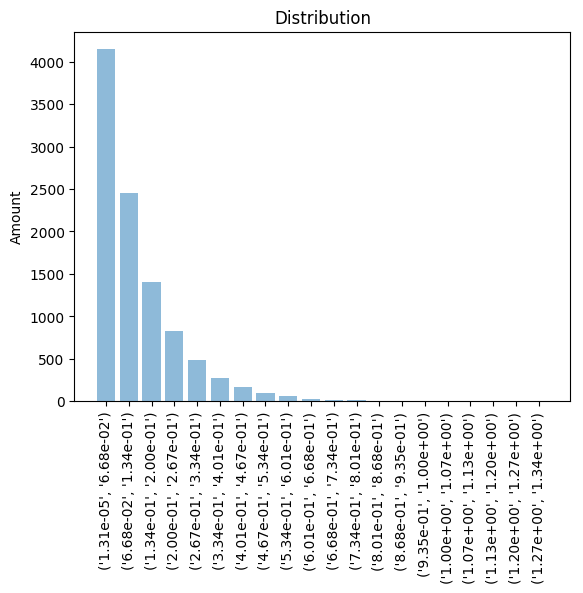

Expected value:  0.12423269072807702
Dispersion:  0.01552796267005896
X^2:  5.02436630814292


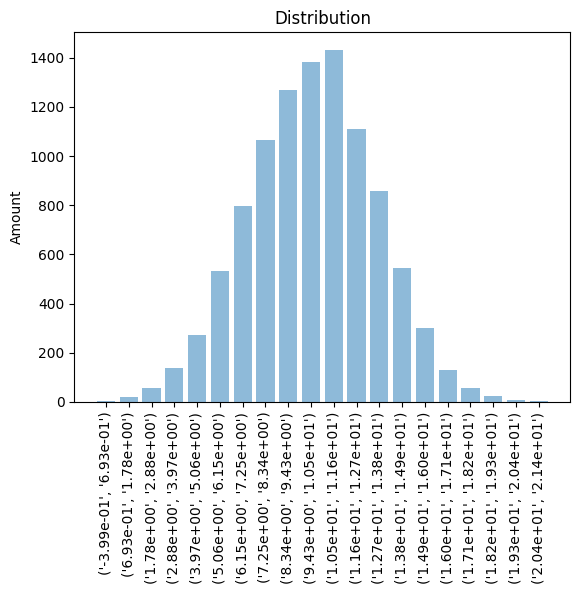

Expected value:  10.048741613999866
Dispersion:  9.067246551289045
X^2:  23.44120647876668


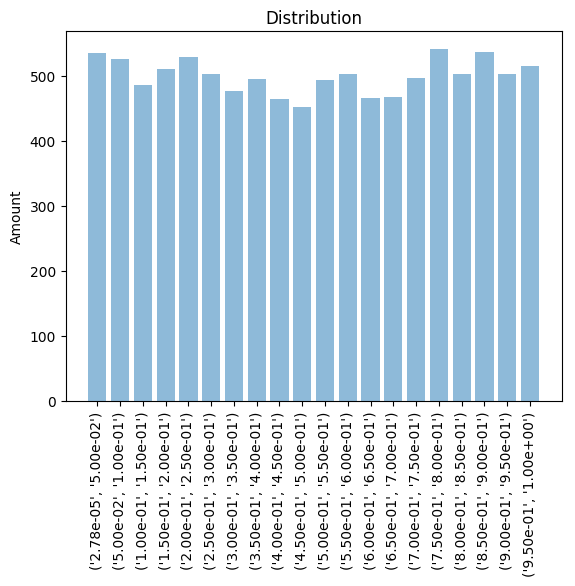

Expected value:  0.49951718149825464
Dispersion:  0.08578704632533389
X^2:  25.311999999999998


In [12]:
def explore_generator(generator, **kwargs):
    helper = Helper()

    predicts = {
        first_generator: helper.get_expected_amount_1,
        second_generator: helper.get_expected_amount_2,
        third_generator: helper.get_expected_amount_3,
    }
    
    arr = generate(generator, **kwargs)
    intervals = helper.get_intervals(arr)
    show(intervals)
    
    expected = helper.expectation(arr)
    print('Expected value: ', expected)
    print('Dispersion: ', helper.dispersion(arr, expected))
    print('X^2: ', helper.get_ksi_squared(intervals, predicts[generator], **kwargs))


explore_generator(first_generator, lambda_=8)
explore_generator(second_generator, sigma=3, a=10)
explore_generator(third_generator, a=5**13, c=2*31)